Application of Antenna pattern onto the received meaurements

In [1]:
%reset -f

import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
import branca.colormap as cm

import sys
sys.path.append('../python')
from earfcn_to_freq import earfcn_to_freq
from haversine import haversine
from calc_bearing import calc_bearing
from gain_calc import gain_calc

df = pd.read_csv('../data/qualipoc_data/cbrs_radio_2024_oct_nov.csv', sep=";")
df.rename(columns={'PCI/PSC/BSIC': 'PCI'}, inplace=True)
df['Frequency'] = df['DL EARFCN'].apply(earfcn_to_freq)
df = df[df['DL Bandwidth'] == 20]
df.drop(columns=['Date', 'Time', 'Device Name', 'Carrier Index', 'Technology Band', 'Band Number', 'DL EARFCN', 'SCC Index', 'TxAntennas',\
                 'Frequency Number', 'DL Subcarrier Spacing', 'DL Carriers Radio', 'Cell Id', 'eNB-Id', 'Sector Id', 'Operator', 'DL Bandwidth'], inplace=True)

pci_map = {
    0: { 'BS': 1, 'Latitude': 41.65425, 'Longitude': -86.242694, 'Azimuth': 60, 'Downtilt': 4, 'Height': 21, 'Frequency': 3670 },
    3: { 'BS': 1, 'Latitude': 41.65425, 'Longitude': -86.242694, 'Azimuth': 120, 'Downtilt': 4, 'Height': 21, 'Frequency': 3640 },
    6: { 'BS': 1, 'Latitude': 41.65425, 'Longitude': -86.24375, 'Azimuth': 180, 'Downtilt': 4, 'Height': 21, 'Frequency': 3580 },
    9: { 'BS': 1, 'Latitude': 41.65425, 'Longitude': -86.24375, 'Azimuth': 240, 'Downtilt': 4, 'Height': 21, 'Frequency': 3690 },
    12: { 'BS': 1, 'Latitude': 41.654639, 'Longitude': -86.24375, 'Azimuth': 300, 'Downtilt': 4, 'Height': 29, 'Frequency': 3560 },
    15: { 'BS': 1, 'Latitude': 41.654639, 'Longitude': -86.24375, 'Azimuth': 0, 'Downtilt': 4, 'Height': 29, 'Frequency': 3580 },
    18: { 'BS': 4, 'Latitude': 41.668678, 'Longitude': -86.312222, 'Azimuth': 70, 'Downtilt': -1, 'Height': 12, 'Frequency': 3690 },
    21: { 'BS': 4, 'Latitude': 41.668678, 'Longitude': -86.312222, 'Azimuth': 130, 'Downtilt': -1, 'Height': 12, 'Frequency': 3640 },
    24: { 'BS': 2, 'Latitude': 41.663278, 'Longitude': -86.254139, 'Azimuth': 60, 'Downtilt': 4, 'Height': 44, 'Frequency': 3670 },
    27: { 'BS': 2, 'Latitude': 41.663278, 'Longitude': -86.254139, 'Azimuth': 120, 'Downtilt': 4, 'Height': 44, 'Frequency': 3640 },
    30: { 'BS': 2, 'Latitude': 41.663278, 'Longitude': -86.254139, 'Azimuth': 180, 'Downtilt': 4, 'Height': 44, 'Frequency': 3580 },
    33: { 'BS': 2, 'Latitude': 41.663278, 'Longitude': -86.254139, 'Azimuth': 240, 'Downtilt': 4, 'Height': 44, 'Frequency': 3690 },
    36: { 'BS': 2, 'Latitude': 41.663278, 'Longitude': -86.254139, 'Azimuth': 300, 'Downtilt': 4, 'Height': 44, 'Frequency': 3560 },
    39: { 'BS': 2, 'Latitude': 41.663278, 'Longitude': -86.254139, 'Azimuth': 0, 'Downtilt': 4, 'Height': 44, 'Frequency': 3580 },
    42: { 'BS': 3, 'Latitude': 41.67225, 'Longitude': -86.292778, 'Azimuth': 120, 'Downtilt': 4, 'Height': 33, 'Frequency': 3670 },
    45: { 'BS': 3, 'Latitude': 41.67225, 'Longitude': -86.292778, 'Azimuth': 180, 'Downtilt': 4, 'Height': 33, 'Frequency': 3640 },
    48: { 'BS': 3, 'Latitude': 41.67225, 'Longitude': -86.292778, 'Azimuth': 240, 'Downtilt': 4, 'Height': 33, 'Frequency': 3690 },
    51: { 'BS': 3, 'Latitude': 41.67225, 'Longitude': -86.292778, 'Azimuth': 300, 'Downtilt': 4, 'Height': 33, 'Frequency': 3580 },
}
df_pci_map = pd.DataFrame.from_dict(pci_map, orient='index').reset_index()
df_pci_map.rename(columns={'index': 'PCI'}, inplace=True)
del pci_map

df = df.merge(df_pci_map[['PCI', 'BS', 'Latitude', 'Longitude', 'Azimuth', 'Downtilt', 'Height']], on='PCI', how='left')
df.rename(columns={'Latitude_x': 'ue_Latitude', 'Latitude_y': 'bs_Latitude', 'Longitude_x': 'ue_Longitude', 'Longitude_y': 'bs_Longitude',\
                   'Azimuth': 'bs_Azimuth', 'Downtilt': 'bs_Downtilt', 'Height': 'bs_Height'}, inplace=True)
del df_pci_map

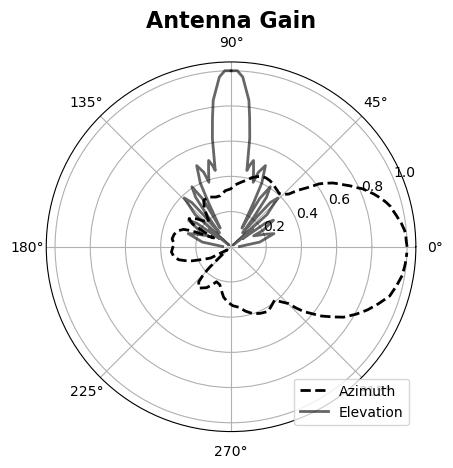

In [5]:
df_antenna = pd.read_csv('../data/antenna.csv')
# df_antenna = df_antenna.sort_values('angle_azimuth')
df_antenna['angle_azimuth'] = df_antenna['angle_azimuth'].apply(lambda x: x * (3.14159/180))
df_antenna['angle_elevation'] = df_antenna['angle_elevation'].apply(lambda x: x * (3.14159/180))
plt.polar(df_antenna['angle_azimuth'], df_antenna['gain_azimuth'], color='black', linewidth=2, linestyle='dashed')
plt.polar(df_antenna['angle_elevation'], df_antenna['gain_elevation'], np.pi-df_antenna['angle_elevation'], df_antenna['gain_elevation'], color='black' ,linewidth=2, alpha=0.6)
plt.legend(['Azimuth', 'Elevation'], loc='lower right')
plt.title('Antenna Gain', fontsize=16, fontweight='bold')
plt.show()
# plt.savefig('antenna_pattern.png',dpi=300)

In [5]:
df[['Distance_2d', 'Distance_3d']] = df.apply(lambda row: haversine(row['ue_Latitude'], row['ue_Longitude'],
                                                                    row['bs_Latitude'], row['bs_Longitude'], row['bs_Height']), axis=1, result_type='expand')
df['Distance_3d_log'] = 10 * np.log10(df['Distance_3d'])
df['Distance_3d_log'] = 10 * np.log10(df['Distance_3d'])
df['ue_Elevation'] = 90 - np.rad2deg(np.arctan(df['bs_Height'] / df['Distance_2d']))

df['ue_Azimuth'] = df.apply(lambda row: calc_bearing(row['bs_Latitude'], row['bs_Longitude'], row['ue_Latitude'], row['ue_Longitude'], row['bs_Azimuth']), axis=1)

df[['gain_Azimuth', 'gain_Elevation']] = 17 * df.apply(lambda row: pd.Series(gain_calc(df_antenna, row['ue_Azimuth'], row['ue_Elevation'])), axis=1)
# It is not 20Mhz/15khz as there are 100 PRBs in 20Mhz conf (rest are guard bands)
df['bs_Power'] = 30 + (df['gain_Azimuth']*df['gain_Elevation']/17) - 10*np.log10(1200)

In [6]:
X_linD = df[['bs_Power', 'Distance_3d']]
X_linD_gps = df[['bs_Power', 'Distance_3d', 'ue_Latitude', 'ue_Longitude']]
X_logD = df[['bs_Power', 'Distance_3d_log']]
X_logD_gps = df[['bs_Power', 'Distance_3d_log', 'ue_Latitude', 'ue_Longitude']]

Y = df['bs_Power']